In [1]:
import pandas as pd 
import numpy as np 
import random as rd 
import math 
import matplotlib.pyplot as plt

### Initial solution generation function. This function first generates a list of tasks with their indices in increasing order

In [2]:
def Initial_Solution(s, show = False):
    sol = np.arange(s)
    Sol_list = list(sol)
    for i in range(len(sol)):
        Sol_list[i] = 'T' + str(Sol_list[i]+1)
    for i in range(len(sol)): 
        x = rd.randint(0, s-1)
        y = rd.randint(0, s-1)
        t1 = Sol_list[x]
        t2 = Sol_list[y]
        Sol_list[x] = t2
        Sol_list[y] = t1
    return Sol_list

### A matrix generator function for precedence relations of tasks 

In [3]:
def Precedence_Matrix(tasks, Prec):
    Prec_Matrix = np.zeros((len(tasks),len(tasks)), int)
    for i in tasks.index:
        for j in tasks.index: 
            for k in Prec.index: 
                if tasks.iloc[i]['Task'] == Prec.iloc[k]['TASK']:
                    if tasks.iloc[j]['Task'] == Prec.iloc[k][Prec.columns[1]]:
                        Prec_Matrix[j,i] = 1
    return Prec_Matrix

### After a solution is generated. This solution must be reordered according to the precedence relations. Otherwise the solution will be infeasible 

In [4]:
def Make_Solution_Feasible(solution, Prec):
    lsol = solution
    for i in range(len(lsol)):
        for j in range(i, len(lsol)):
            if(i<j):
                for k in Prec.index: 
                    if solution[j] == Prec.iloc[k][Prec.columns[0]] and solution[i] == Prec.iloc[k][Prec.columns[1]]: 
                        temp1 = lsol[i] 
                        temp2 = lsol[j] 
                        lsol[i] = temp2 
                        lsol[j] = temp1
                        solution = lsol 
    lsol.reverse()
    return lsol

### For a given problem, this function calculates the number of possible workstations for tasks  having task durations that are greater than the half of the cycle time 

In [5]:
def Total_Number_Possible_Work_Station(data, c):
    x =0
    for i in data.index: 
        if data.iloc[i]['Duration'] > c/2:
            x = x +1 
    return x 

### This function helps smooting index calculation function to find the index of a given task for tasks data frame

In [6]:
def get_index(s):
    k = s[1:]
    k = int(k)-1
    return k

### This function calculates the smooting index of a given solution 

In [7]:
 def Smoothing_index(solution, WS, tasks, show = False):   
    WS_time = np.zeros(WS, float)
    k =0
    j =0 
    solution2 = solution[:]
    i = 0
    l = 0
    while i < len(solution2):
        y = float(tasks.loc[get_index(solution2[i])][tasks.columns[1]]) 
        if WS_time[j] +  y <= Cycle_time:
            WS_time[j] = WS_time[j] + y
            i = i +1 
            l = l +1 
        else: 
            j = j+1 
    WS_Max = WS_time.max()
    ns = np.zeros(WS, float)
    ns = ((WS_Max- WS_time)**2)/(WS)
    SI = ns.sum()
    SI = math.sqrt(SI)
    WS_time = WS_time[WS_time != 0]
    if show == True: 
        print("#"*8, "The Smoothing Index value for {} solution sequence is: {}".format(solution ,SI),"#"*8)
        print("#"*8, "The number of workstations for {} solution sequence is: {}".format(solution ,WS_time.size),"#"*8)
        print("#"*8, "The workloads of workstation for {} solution sequence are: {}".format(solution ,WS_time),"#"*8)
    return SI

### This function is to create the tabu structures of all possible and feasible moves. It keeps how many iterations remaining left to free moves and the last recorded values of  moves 

In [8]:
def Create_Tabu_Strcuture(tasks, Prec_Matrix):
    Tabu_Structure = pd.DataFrame(columns=['Task_1', 'Task_2', 'Feasible', 'Tabued','Value']); 
    for i in range(len(tasks)):
        for j in range(len(tasks)):
            if i<j: 
                if(Prec_Matrix[i,j]==0 and Prec_Matrix[j,i]==0): 
                    Tabu_Structure.loc[len(Tabu_Structure.index)] = ["T" + str(i+1), "T" + str(j+1), "T", 0, 1000] 
                else: 
                    Tabu_Structure.loc[len(Tabu_Structure.index)] = ["T" + str(i+1), "T" + str(j+1), "F", 0, 1000] 
    return Tabu_Structure

### This function is to swap randomly selected two tasks' poositions in a given solution  

In [9]:
def N_Swap(solution, i1, i2):
    sol = solution[:]; 
    temp1 = sol[i1]
    temp2 = sol[i2]
    sol[i1] = temp2
    sol[i2] = temp1
    sol = Make_Solution_Feasible(sol, Prec)
    return sol

### The graphical illustration of a solution. It retuns a plot that shows workstations' workloads and cylce time

In [10]:
def Make_Solution_to_plot(solution, WS, tasks, Cycle_time):
    data = {}   
    WS_time = np.zeros(WS, float)
    k =0
    j =0 
    i = 0
    l = 0
    m = "W"+str(j+1)
    while i < len(solution):
        y = float(tasks.loc[get_index(solution[i])][tasks.columns[1]]) 
        if WS_time[j] +  y <= Cycle_time:
            WS_time[j] = WS_time[j] + y
            i = i +1 
            l = l +1 
            data[m] = WS_time[j]
        else: 
            j = j+1 
            m = "W"+str(j+1)
            data[m] = 0           
    WS_Names = list(data.keys())
    WS_Workloads = list(data.values())
    fig = plt.figure()
    plt.axhline(y = Cycle_time, color = 'r', linestyle = '-')
    plt.bar(WS_Names, WS_Workloads, color ='blue', width = 0.4)
    plt.xlabel("Workstations ")
    plt.ylabel("Time")
    plt.title("The total workloads of workstations")
    return plt

### Getting data (task names and durations)  from a txt file to put them a dataframe 

In [11]:
tasks = pd.DataFrame(columns=['Task', 'Duration']); 

# Data is available in Appendix B of the book's GitHub repo and can be read directly using URL begins with raw.
tasks= pd.read_csv("https://raw.githubusercontent.com/Optimization-Algorithms-Book/Code-Listings/main/Appendix%20B/data/ALBP/ALB_TS_DATA.txt", sep =",")
tasks.head()

,Task,Duration
0,T1,2
1,T2,3
2,T3,3
3,T4,1
4,T5,3


### these codes are to get data (tasks' immediate precedessors) from a txt file to put them a dataframe 

In [12]:
Prec= pd.read_csv("https://raw.githubusercontent.com/Optimization-Algorithms-Book/Code-Listings/main/Appendix%20B/data/ALBP/ALB_TS_PRECEDENCE.txt", sep =",")
Prec.columns=['TASK', 'IMMEDIATE_PRECEDESSOR']
Prec.head()

,TASK,IMMEDIATE_PRECEDESSOR
0,T3,T1
1,T4,T2
2,T5,T3
3,T5,T4
4,T6,T4


### Create a precedence matrix of tasks 

In [13]:
Prec_Matrix = Precedence_Matrix(tasks, Prec)
Prec_Matrix

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [14]:
# the cycle time for the assembly line balancing problem  where Cycle_time = daily demand / daily work time 
# Cycle_time = 10 for the second example
Cycle_time = 4
# the total sum of processing times
total_processing_time = tasks["Duration"].sum()
#the number of tasks 
N = tasks["Duration"].count()
# the number of maximum workstation where TN_M_WS = raundup(total_processing_time/N)
TN_M_WS = math.ceil(total_processing_time/N)
# the number of possible workstations for tasks  having task durations that are greater than the half of the cycle time 
TN_P_WS = Total_Number_Possible_Work_Station(tasks, Cycle_time)
# the accual number of workstations will be greater than or equal to  TN_M_WS and/or TN_P_WS
WS = max(TN_M_WS,TN_P_WS) +1 
# the average workstation workload 
average_WS_time = total_processing_time / WS

In [15]:
# generating a initial solution  
solution = Initial_Solution(len(tasks))
# making the generated feasible solution a feasible one considering the task precedence relations 
solution = Make_Solution_Feasible(solution, Prec)
solution

['T2', 'T4', 'T1', 'T6', 'T5', 'T3']

In [16]:
# calculating the smoothing index of the solution 
SI = Smoothing_index(solution, WS, tasks, True)
print(SI)

######## The Smoothing Index value for ['T2', 'T4', 'T1', 'T6', 'T5', 'T3'] solution sequence is: 1.1832159566199232 ########
######## The number of workstations for ['T2', 'T4', 'T1', 'T6', 'T5', 'T3'] solution sequence is: 5 ########
######## The workloads of workstation for ['T2', 'T4', 'T1', 'T6', 'T5', 'T3'] solution sequence are: [4. 2. 3. 3. 3.] ########
1.1832159566199232


In [17]:
# generating a tabu structure related the given problem and assigning it to a dataframe 
Tabu_Structure = Create_Tabu_Strcuture(tasks, Prec_Matrix)
# calculating the size of the tabu structure 
K = math.comb(len(tasks),2)
# displaying the tabu structure 
Tabu_Structure.head(K)

,Task_1,Task_2,Feasible,Tabued,Value
0,T1,T2,T,0,1000
1,T1,T3,F,0,1000
2,T1,T4,T,0,1000
3,T1,T5,T,0,1000
4,T1,T6,T,0,1000
5,T2,T3,T,0,1000
6,T2,T4,F,0,1000
7,T2,T5,T,0,1000
8,T2,T6,T,0,1000
9,T3,T4,T,0,1000


In [18]:
# Termination is the limit of the how many iterations is to be done in the Tabu Search algorithm 
Termination =0
# Tenure is the size of the Tabu list for how many iterations a solution component is kept as Tabu
tenure = 3

In [19]:
# Tabu search algorithm 
while Termination <100: 
    i1 = 0
    i2 = 0
    while i1==i2: 
        i1 = rd.randint(0, len(solution)-1)
        i2 = rd.randint(0, len(solution)-1)

    t1 = solution[i1]
    t2 = solution[i2]
    # solution incumbent solution  
    # sol_n neighborhood solution of solution 
    # sol_nb the best neigborhood solution of incumbent solution
    # sol_best the best solution in the memory 
    sol_best = solution[:]
    SI_best = SI
    sol_nb = solution[:]
    SI_nb = SI
    sol_n = solution[:]
    SI_n = SI

    for k in Tabu_Structure.index:
        if (t1 == Tabu_Structure.iloc[k][Tabu_Structure.columns[0]] and t2 == Tabu_Structure.iloc[k][Tabu_Structure.columns[1]] and Tabu_Structure.iloc[k][Tabu_Structure.columns[2]] =="T" and Tabu_Structure.iloc[k][Tabu_Structure.columns[3]] ==0) or (t2 == Tabu_Structure.iloc[k][Tabu_Structure.columns[0]] and t1 == Tabu_Structure.iloc[k][Tabu_Structure.columns[1]] and Tabu_Structure.iloc[k][Tabu_Structure.columns[2]] =="T" and Tabu_Structure.iloc[k][Tabu_Structure.columns[3]] ==0):
            sol_n = N_Swap(solution, i1, i2)
            SI_n = Smoothing_index(sol_n, WS, tasks)
            Tabu_Structure.iat[k, 4]=SI_n
            Tabu_Structure.iat[k, 3]=tenure
            if SI_nb > SI_n: 
                SI_nb = SI_n
                sol_nb = sol_n[:]              
            if SI_best > SI_n: 
                SI_best = SI_n
                sol_best = sol_n[:]  
        else: 
            #aspiration 
            if (t1 == Tabu_Structure.iloc[k][Tabu_Structure.columns[0]] and t2 == Tabu_Structure.iloc[k][Tabu_Structure.columns[1]] and Tabu_Structure.iloc[k][Tabu_Structure.columns[2]] =="T" and Tabu_Structure.iloc[k][Tabu_Structure.columns[3]] >0) or (t2 == Tabu_Structure.iloc[k][Tabu_Structure.columns[0]] and t1 == Tabu_Structure.iloc[k][Tabu_Structure.columns[1]] and Tabu_Structure.iloc[k][Tabu_Structure.columns[2]] =="T" and Tabu_Structure.iloc[k][Tabu_Structure.columns[3]] >0):
                sol_n = N_Swap(solution, i1, i2)
                SI_n = Smoothing_index(sol_n, WS, tasks)
                Tabu_Structure.iat[k, 4]=SI_n
                t = Tabu_Structure.iloc[k][Tabu_Structure.columns[3]] 
                Tabu_Structure.iat[k, 3]=t-1
                if SI_best > SI_n: 
                    SI_best = SI_n
                    sol_best = sol_n[:]    
    solution = sol_nb[:]
    SI = SI_nb
    Termination = Termination + 1
print(sol_best)   
print(SI_best)

['T2', 'T1', 'T4', 'T3', 'T6', 'T5']
0.0


In [20]:
Tabu_Structure.head(K)

,Task_1,Task_2,Feasible,Tabued,Value
0,T1,T2,T,3,1.183216
1,T1,T3,F,0,1000
2,T1,T4,T,0,1.183216
3,T1,T5,T,3,1.183216
4,T1,T6,T,2,1.183216
5,T2,T3,T,1,1.183216
6,T2,T4,F,0,1000
7,T2,T5,T,2,1.183216
8,T2,T6,T,0,1.183216
9,T3,T4,T,3,1.183216


### Display the final solution's details 

In [21]:
Smoothing_index(solution, WS, tasks, True)

######## The Smoothing Index value for ['T2', 'T1', 'T4', 'T3', 'T6', 'T5'] solution sequence is: 0.0 ########
######## The number of workstations for ['T2', 'T1', 'T4', 'T3', 'T6', 'T5'] solution sequence is: 5 ########
######## The workloads of workstation for ['T2', 'T1', 'T4', 'T3', 'T6', 'T5'] solution sequence are: [3. 3. 3. 3. 3.] ########


0.0

### Plot the solution 

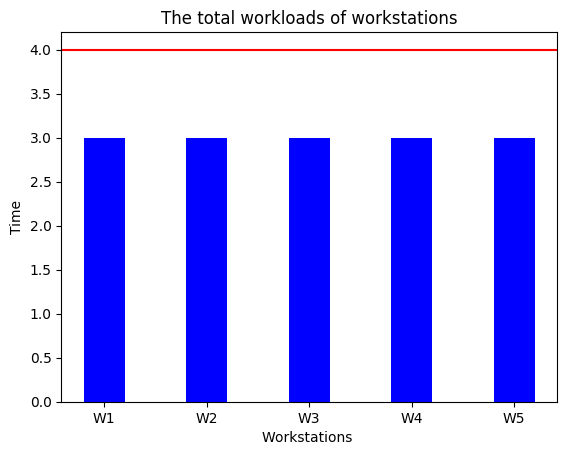

In [22]:
plt = Make_Solution_to_plot(solution, WS, tasks, Cycle_time)
plt.show()